In [1]:
# Dependencies
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from config import db_password 
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter
import tensorflow as tf
import warnings
warnings.simplefilter(action = "ignore") 

In [3]:
# Connect to diabetes RDS database
# Define connection
DATABASES = {
    'production':{
        'NAME': 'Diabetes_db',
        'USER': 'postgres',
        'PASSWORD': db_password,
        'HOST': 'diabetesdb.cwyccvgtauvd.us-east-2.rds.amazonaws.com',
        'PORT': 5432,
    },
}

# Choose the database
db = DATABASES['production']

# construct an engine connection string
engine_string = "postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}".format(
    user = db['USER'],
    password = db['PASSWORD'],
    host = db['HOST'],
    port = db['PORT'],
    database = db['NAME'],
)

# create sqlalchemy engine
engine = create_engine(engine_string)

# read a table from database into pandas dataframe, replace "tablename" with your table name
df = pd.read_sql_table('diabetes',engine)
df.shape

(945188, 52)

In [4]:
# Remove NaN Values from all other fields (Features); replace with a value that is unused in the raw data set (aka 100)
df.fillna(100, inplace=True)

In [5]:
# split the data into X (features) and y (target):

y = df['diabete3']
X = df.drop(columns=['diabete3','id','_state','iyear','htm4','wtkg3'])
X.describe()

,genhlth,physhlth,menthlth,poorhlth,hlthpln1,persdoc2,medcost,checkup1,bphigh4,toldhi2,...,adfail,adthink,admove,mistmnt,adanxev,_race,_age_g,_bmi5,_frutsum,_vegesum
count,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,...,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,9.451880e+05,9.451880e+05
mean,2.592309,60.631176,64.399970,77.237957,1.119785,1.391746,1.900935,1.601569,2.215451,15.056277,...,99.036208,99.093822,99.253851,96.388232,96.389104,1.990272,4.422571,2603.159951,1.382295e+02,1.845304e+02
std,1.154237,37.041350,35.926294,35.066144,0.504575,0.817551,0.438216,1.270311,1.060227,33.788468,...,7.721615,7.306799,6.044232,18.475206,18.474111,2.495198,1.526921,908.311942,1.311997e+02,1.438683e+02
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,5.397605e-79,5.397605e-79
25%,2.000000,15.000000,25.000000,88.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000,3.000000,2289.000000,6.000000e+01,1.000000e+02
50%,3.000000,88.000000,88.000000,88.000000,1.000000,1.000000,2.000000,1.000000,3.000000,2.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000,5.000000,2645.000000,1.000000e+02,1.570000e+02
75%,3.000000,88.000000,88.000000,100.000000,1.000000,1.000000,2.000000,2.000000,3.000000,2.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000,6.000000,3034.000000,2.000000e+02,2.330000e+02
max,100.000000,100.000000,99.000000,100.000000,9.000000,9.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,6.000000,9995.000000,1.500000e+04,2.046000e+04


In [6]:
# check balance of target column
y.value_counts()

0.0    809602
1.0    119717
4.0     15869
Name: diabete3, dtype: int64

In [7]:
# Transform y values to 0 = no diabetes; 1 = yes, diabetes.  Per BRFSS codebook 4 = prediabetes and we consider this as 'yes, diabetes'

y = y.replace({4:1})
y.value_counts()

0.0    809602
1.0    135586
Name: diabete3, dtype: int64

In [8]:
# Split into training and testing data sets
# Remove test size paramenter
X_train, X_test, y_train, y_test = train_test_split(X,y)

Counter(y_train)

Counter({0.0: 606872, 1.0: 102019})

In [9]:
# Scale the data

scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [10]:
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 92

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 92)                4324      
                                                                 
 dense_1 (Dense)             (None, 1)                 93        
                                                                 
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [12]:
# Train the model
fit_model = nn.fit(X_train,y_train,epochs=100)

Epoch 1/100
22153/22153 [==============================] - 45s 2ms/step - loss: 0.9348 - accuracy: 0.8095
Epoch 2/100
22153/22153 [==============================] - 43s 2ms/step - loss: 0.5904 - accuracy: 0.8219
Epoch 3/100
22153/22153 [==============================] - 42s 2ms/step - loss: 0.4613 - accuracy: 0.8339
Epoch 4/100
22153/22153 [==============================] - 43s 2ms/step - loss: 0.3759 - accuracy: 0.8482
Epoch 5/100
22153/22153 [==============================] - 42s 2ms/step - loss: 0.3426 - accuracy: 0.8573
Epoch 6/100
22153/22153 [==============================] - 42s 2ms/step - loss: 0.3337 - accuracy: 0.8597
Epoch 7/100
22153/22153 [==============================] - 42s 2ms/step - loss: 0.3322 - accuracy: 0.8598
Epoch 8/100
22153/22153 [==============================] - 42s 2ms/step - loss: 0.3306 - accuracy: 0.8601
Epoch 9/100
22153/22153 [==============================] - 43s 2ms/step - loss: 0.3297 - accuracy: 0.8600
Epoch 10/100
22153/22153 [====================

In [ ]:
# The NN took 1h 9m 23s to complete and the accuracies were similar to those from the RandomForestClassifier, 
# even thogh the RFC took only 1m 47.8 seconds to create and fit

In [13]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


7385/7385 - 9s - loss: 0.3219 - accuracy: 0.8633 - 9s/epoch - 1ms/step
Loss: 0.321900337934494, Accuracy: 0.8632695078849792


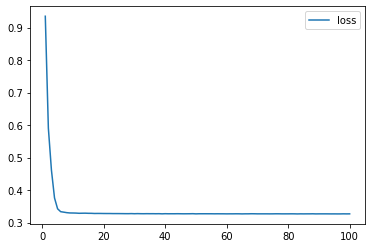

In [14]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

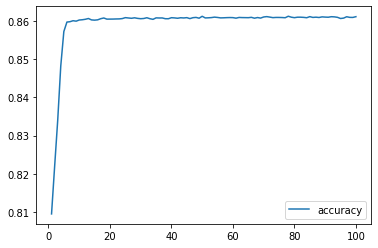

In [15]:
# Plot the accuracy
history_df.plot(y="accuracy")

In [16]:
# Let's try the Nueral Network on the simplest data set that we evaluated with the RFC model
X=df[['_age_g','sex','bphigh4','exerany2','_race','_bmi5']]
X.head()


,_age_g,sex,bphigh4,exerany2,_race,_bmi5
0,5.0,2.0,1.0,2.0,1.0,4018.0
1,4.0,2.0,3.0,1.0,1.0,2509.0
2,6.0,2.0,3.0,100.0,1.0,2204.0
3,5.0,2.0,1.0,2.0,1.0,2819.0
4,5.0,2.0,3.0,2.0,1.0,2437.0


In [17]:
# Re-run model

# Split into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X,y)

Counter(y_train)

Counter({0.0: 607087, 1.0: 101804})

In [18]:
# Scale the data

scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [19]:
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 12

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12)                84        
                                                                 
 dense_3 (Dense)             (None, 1)                 13        
                                                                 
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [21]:
# Train the model (reducing epochs based on how quickly accuracy was achieved in the first model)
fit_model = nn.fit(X_train,y_train,epochs=25)

Epoch 1/25
22153/22153 [==============================] - 38s 2ms/step - loss: 9.2128 - accuracy: 0.8365
Epoch 2/25
22153/22153 [==============================] - 35s 2ms/step - loss: 0.3837 - accuracy: 0.8478
Epoch 3/25
22153/22153 [==============================] - 35s 2ms/step - loss: 0.3761 - accuracy: 0.8494
Epoch 4/25
22153/22153 [==============================] - 35s 2ms/step - loss: 0.3723 - accuracy: 0.8508
Epoch 5/25
22153/22153 [==============================] - 35s 2ms/step - loss: 0.3664 - accuracy: 0.8527
Epoch 6/25
22153/22153 [==============================] - 35s 2ms/step - loss: 0.3599 - accuracy: 0.8547
Epoch 7/25
22153/22153 [==============================] - 35s 2ms/step - loss: 0.3540 - accuracy: 0.8562
Epoch 8/25
22153/22153 [==============================] - 35s 2ms/step - loss: 0.3519 - accuracy: 0.8563
Epoch 9/25
22153/22153 [==============================] - 35s 2ms/step - loss: 0.3513 - accuracy: 0.8566
Epoch 10/25
22153/22153 [==============================

In [22]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


7385/7385 - 8s - loss: 0.3521 - accuracy: 0.8556 - 8s/epoch - 1ms/step
Loss: 0.3521304130554199, Accuracy: 0.8556308150291443
